# Finding Clusters of Job Posting Skills

## Objective 

Now that we have narrowed down our job postings to those that are most relevant, we want to see what types of skills are typically in these jobs. We will cluster the skill requirements for the job postings and visualize the clusters of skill requirements with word clouds.

## Workflow 

1. Determine which part of the HTML job postings to use for generating clusters of skill requirements.


2. Transform the section of HTML documents you chose to use into TF-IDF vectors.


3. Use dimensionality reduction with singular value decomposition (SVD, also known as latent semantic analysis, or LSA) on our TF-IDF vectors, which can improve clustering performance.


4.Use k-means to cluster the dimensionally reduced data. Decide on the optimal number of clusters.


5. Visualize the text clusters with word frequency distributions and/or word clouds. Confirm that the clusters make sense—if not, alter SVD, TF-IDF, and/or k-means parameters and try clustering again.

## Importance to project

Having relevant job postings is great, but it doesn’t tell us everything about the content of those job postings. **One way to understand a summary of the important parts of the job postings is to look at the skill requirements as text clusters.** This will help us understand which types of data science jobs are out there, and what sort of skills are required.

In [227]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from jupyterthemes import jtplot
from wordcloud import WordCloud

from tqdm import tqdm_notebook

jtplot.style()
%matplotlib inline
np.random.seed(0)


In [149]:
df = pd.read_pickle('../data/step2_df.pk')
df.head()

,title,body,bullets,cosine_similarity
0,Post-doc: Dissemination/implementation and/or ...,Post-doc: Dissemination/implementation and/or ...,(),0.135607
1,Bioinformatics Associate Data Scientist - San ...,Bioinformatics Associate Data Scientist - San ...,(Work on designing and implementing a framewor...,0.109464
2,"Senior Data Scientist - Authorship - Oakland, CA","Senior Data Scientist - Authorship - Oakland, ...","(Work closely with domain experts, project eng...",0.107245
3,data scientist - United States,data scientist - United States\nJob Summary\nA...,(Excellent understanding of machine learning t...,0.107127
4,Data Scientist - United States,Data Scientist - United States\nEV Technologie...,"(Selecting features, building and optimizing c...",0.102533


## 1. Get TF-IDF Vectors

In [153]:
bull_list = [item for bull in df.bullets for item in bull]
len(bull_list)

1840

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(bull_list)
tfidf_matrix.shape

(1840, 2665)

In [72]:
tfidf_np_matrix = tfidf_matrix.toarray()
type(tfidf_np_matrix)

numpy.ndarray

## 2. Dimensionality reduction (SVD)

In [180]:
from sklearn.decomposition import TruncatedSVD

dim = 500
svd = TruncatedSVD(n_components=dim)
lsa = svd.fit_transform(tfidf_matrix)

In [181]:
#500 dimensions explains roughly 80% variance in data
svd.explained_variance_ratio_.sum()

0.7971184646049503

array([0.00995277, 0.02435586, 0.03795345, 0.05109833, 0.06340417,
       0.07232644, 0.08044622, 0.08800151, 0.09517406, 0.10196568])

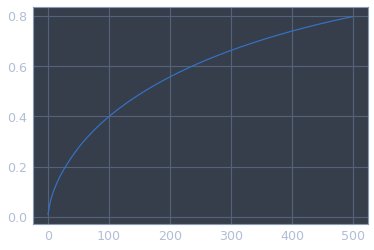

In [182]:
plt.plot(range(svd.explained_variance_ratio_.shape[0]),svd.explained_variance_ratio_.cumsum())
svd.explained_variance_ratio_.cumsum()[:10]

In [183]:
svd.explained_variance_ratio_[:100].sum()

0.39733100028992285

We’ll use 100 for the n_components as we found this accounts for almost 50% of the explained
variance in the data with the SVD, and is the value suggested by the documentation. However,
you can also use a lower value of 50, which should make the ‘topics’ in the LSA a bit more broad.

In [191]:
from sklearn.preprocessing import Normalizer

In [192]:
svd = TruncatedSVD(n_components=100)
lsa = svd.fit_transform(tfidf_matrix)
norm = Normalizer().fit_transform(lsa)

In [193]:
magnitude = np.linalg.norm(lsa[0])
print(f"The magnitude of the first row is {magnitude:.2f}")

The magnitude of the first row is 0.33


In [194]:
magnitude = np.linalg.norm(norm[0])
print(f"The magnitude of the first row is {magnitude:.2f}")

The magnitude of the first row is 1.00


# Clustering (K-means)

This task contains two steps : 
    1. Choose optimal number of clusters (Elbow method)
    2. Compute Kmeans clusters

## Choose optimal n_clusters

In [195]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [208]:
def elbow_method(matrix,n_clusters):
    """
    Args:
        matrix
        k_values
    
    Output:
        n_
    """
    wss = []
    silhouette = []
    clusters = range(2, 51)
    for c in tqdm_notebook(clusters):
        km = KMeans(n_clusters=c, random_state=42)
        km.fit(matrix)
        # sklearn kmeans wss is negative
        wss.append(-km.score(matrix))
        silhouette.append(silhouette_score(matrix, km.labels_))
        
    return wss, silhouette
    
    

In [221]:
n_clusters = range(1,60)
wss, silhouette = elbow_method(norm,k_values)

/home/michal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


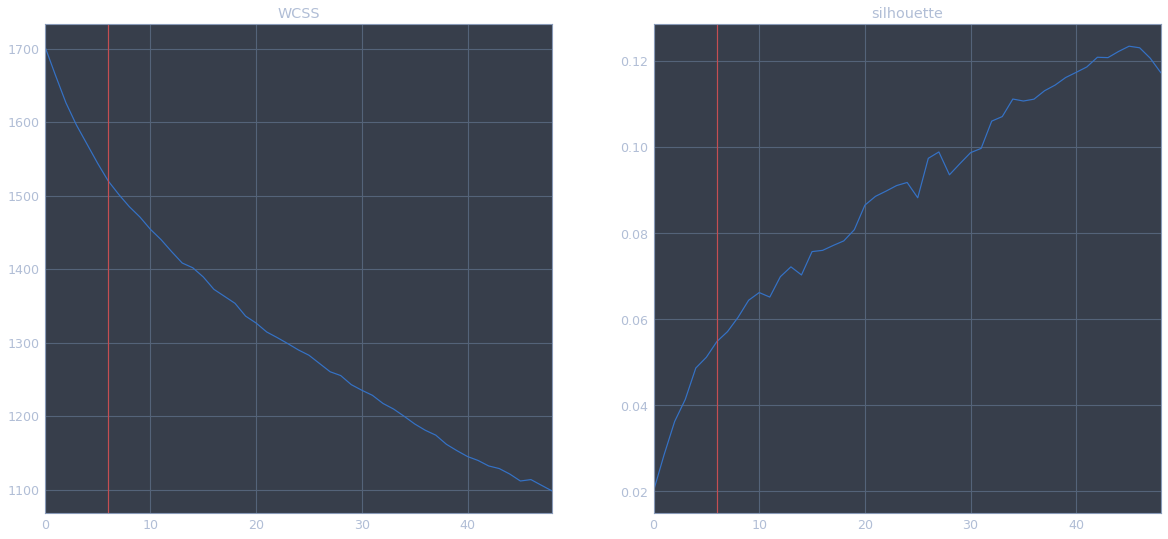

In [255]:
metrics = pd.DataFrame({"wss" : wss, "silhouette": silhouette})

fig,ax = plt.subplots(1,2,figsize=(20,9))

_ = metrics['wss'].plot(ax=ax[0],title="WCSS")
ax[0].axvline(6,c="r")
_ = metrics['silhouette'].plot(ax=ax[1],title="silhouette")
ax[1].axvline(6,c="r")

## Silhouette_analysis

In [256]:
def silhouette_analysis(matrix, k):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(matrix)
    cluster_labels = km.labels_
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(matrix, cluster_labels)
    print("For n_clusters =", k,
    "The average silhouette_score is :", silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(matrix, cluster_labels)
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
        0, ith_cluster_silhouette_values,
        facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 # 10 for the 0 samples
    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([]) # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

#### K = 5

For n_clusters = 5 The average silhouette_score is : 0.04137262774145852


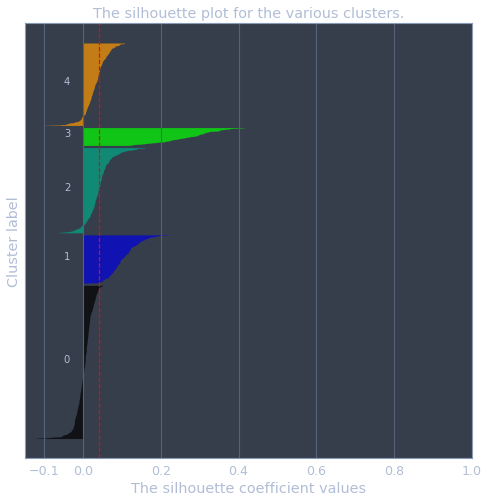

In [236]:
plt.figure(figsize=(8,8))
silhouette_analysis(norm,5)

#### K=6

For n_clusters = 6 The average silhouette_score is : 0.04868868809633756


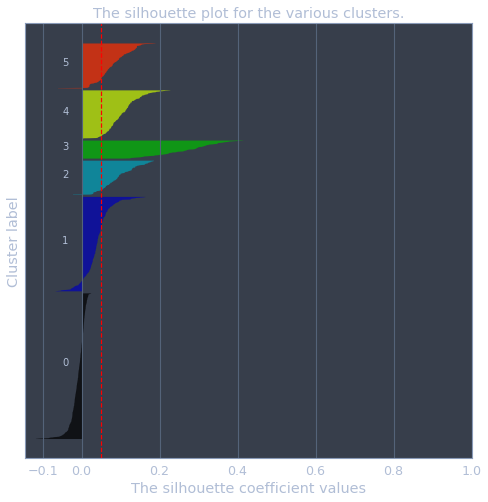

In [238]:
plt.figure(figsize=(8,8))
silhouette_analysis(norm,6)

## K = 20

For n_clusters = 20 The average silhouette_score is : 0.07822843107432342


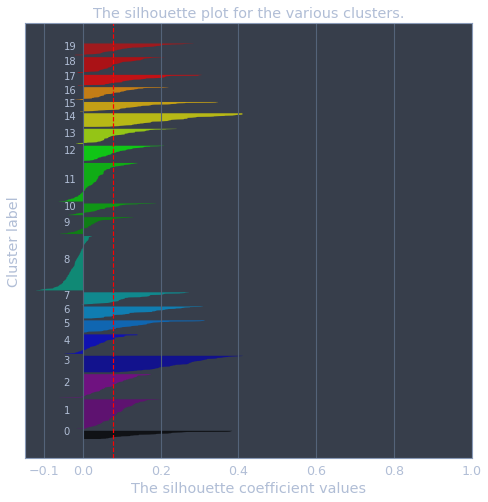

In [241]:
plt.figure(figsize=(8,8))
silhouette_analysis(norm,20)

We will stick with our n_clusters of 6 as the optimal value, since we don’t see any convincing
evidence to use another value. However, you could go with a higher value of clusters for more
specific topics.

In [257]:
clusters = 6 
cluster_model = KMeans(n_clusters=clusters,random_state=42)
cluster_model.fit(norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [271]:
cluster_labels_df = pd.DataFrame({'Cluster': cluster_model.labels_})
cluster_labels_df.head()

,Cluster
0,1
1,1
2,1
3,0
4,1


## Visualize Cluster with word frequency distribution

In [275]:
%who

KMeans	 Normalizer	 TfidfVectorizer	 TruncatedSVD	 WordCloud	 ax	 bull	 bull_list	 bullet_points	 
c	 cl	 cluster_labels_df	 cluster_model	 cluster_to_image	 clusters	 cm	 df	 df_cluster	 
dim	 docs_in_clusters	 elbow_method	 fig	 jtplot	 k_values	 lsa	 magnitude	 metric	 
metrics	 n_clusters	 norm	 normalize	 np	 os	 pd	 plt	 prediction	 
rank_words_by_tfidf	 shrunk_matrix	 shrunk_norm_matrix	 silhouette	 silhouette_analysis	 silhouette_samples	 silhouette_score	 svd	 tfidf_matrix	 
tfidf_np_matrix	 tfidf_vectorizer	 tqdm_notebook	 word_dictionaries	 wss	 


In [276]:
def rank_words_by_tfidf(indices, tfidf_matrix=tfidf_matrix, word_list = tfidf_vectorizer.get_feature_names()):
    """
    Takes indices for a tfidf matrix, sums the TFIDF across the matrix, and returns
    a pandas DataFrame with words ranked from the highest summed TFIDF values,down to lowest.
    The indices argument is intended to be used to filter the DataFrame by,kmeans clusters.
    """
    summed_tfidf = np.asarray(tfidf_matrix[indices].sum(axis=0))[0]
    data = {'Word': word_list, 'Summed TFIDF': summed_tfidf}
    return pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False)

In [277]:
def cluster_to_image(df_cluster, max_words=15):
    indices = df_cluster.index.values
    # get TFIDF-ranked words
    df_ranked_words = rank_words_by_tfidf(indices)[:max_words]
    # create word-to-TFIDF value dictionary for the word cloud
    words_to_score = {word: score
                      for word, score in df_ranked_words[:max_words].values
                      if score != 0}
    # generate the word cloud
    cloud_generator = WordCloud(background_color='white',
                                color_func=_color_func,
                                random_state=1)

    wordcloud_image = cloud_generator.fit_words(words_to_score)

    return wordcloud_image, words_to_score

def _color_func(*args, **kwargs):
# a small function to change the color of the word clouds
    return np.random.choice(['black', 'blue', 'teal', 'purple', 'brown'])

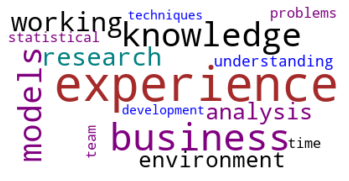

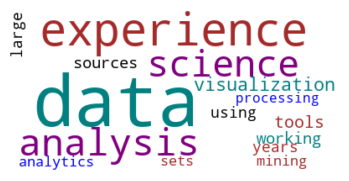

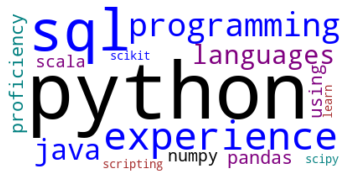

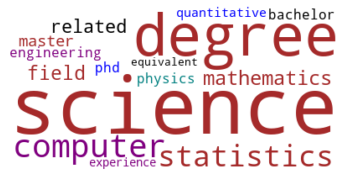

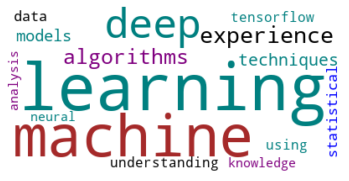

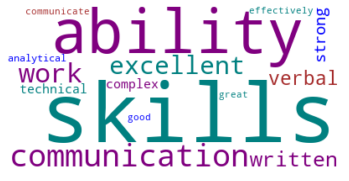

In [279]:
docs_in_clusters = []
word_dictionaries = []
for c in range(clusters):
    df_cluster = cluster_labels_df[cluster_labels_df.Cluster == c]
    wordcloud_image, words_to_score = cluster_to_image(df_cluster)
    word_dictionaries.append(words_to_score)
    plt.imshow(wordcloud_image, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    # we get the number of documents in each cluster
    # for analysis of how well distributed the clusters are
    docs = np.where(cluster_model.labels_ == c)[0]
    docs_in_clusters.append(len(docs))

In [280]:
def plot_word_dict(word_dict):
    """
    Plots frequency distribution of word-to-TFIDF score dictionaries.
    """
    plt.figure()
    x = range(len(word_dict.values()))
    plt.plot(x, list(word_dict.values()))
    plt.xticks(x, word_dict.keys(), rotation=90)
    plt.ylabel('summed TFIDF value')

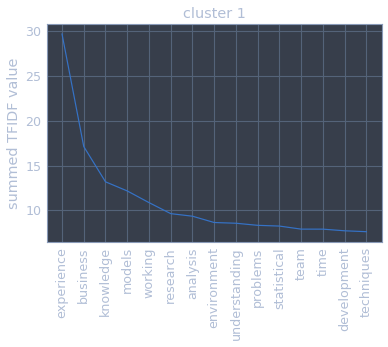

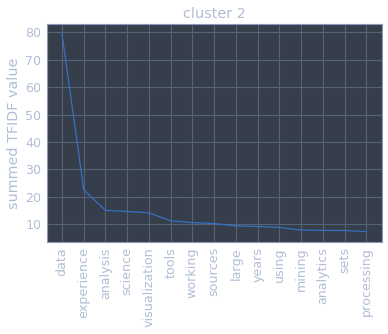

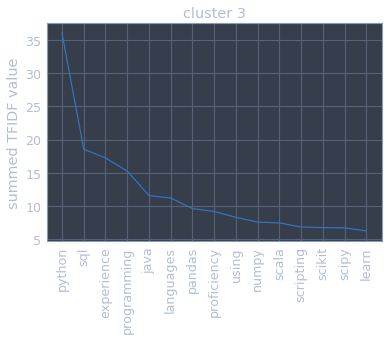

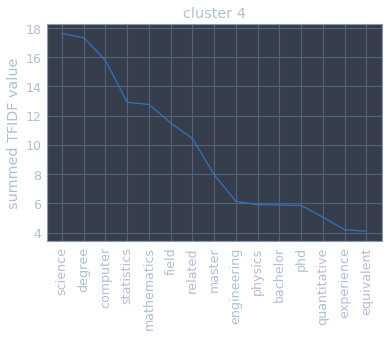

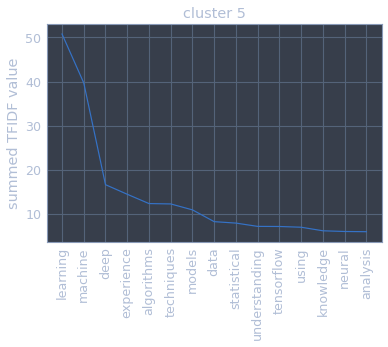

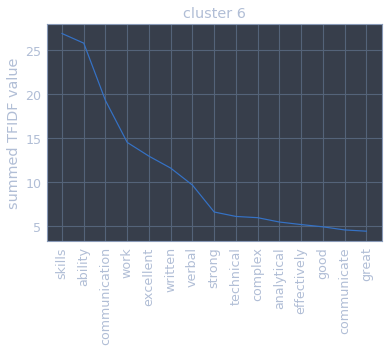

In [281]:
for c in range(len(word_dictionaries)):
    plot_word_dict(word_dictionaries[c])
    plt.title('cluster {}'.format(c + 1))

We’ll look at how many documents (bullet points) are in each cluster to see how well-distributed
our clusters are. It looks like cluster 6 is a catch-all cluster. This tends to happen when clustering
text

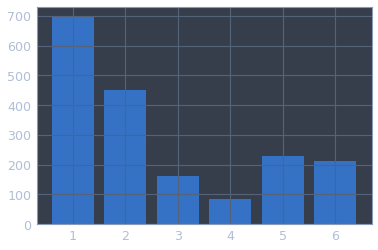

In [282]:
_ = plt.bar(range(1, clusters + 1), docs_in_clusters)

The code below is adapted from the Data Science BookCamp chapter 15.6 ‘Visualizing Text Clusters’. We can plot several word clouds in one figure at a time and explore different numbers of
clusters

In general, our clusters seem to make sense. However, we could increase the number of clusters if
we want to get more specific skills clusters. On the other hand, a small number of clusters makes
interpretation of the data easier.

We can see our clusters cover:
* degree and credential requirements
* data visualization
* research/academics
* deep learning and machine learning
* problem solving and communication
* experience with Python, SQL, some web technology, and Tableau